<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>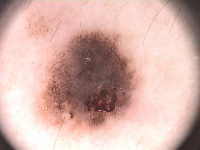</td><td>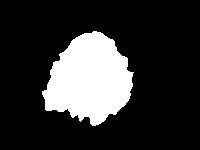</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
#!wget 1https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

In [2]:
#from week_08_semantic_segmentation.Practice.semantic_segmentation import epochs

get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

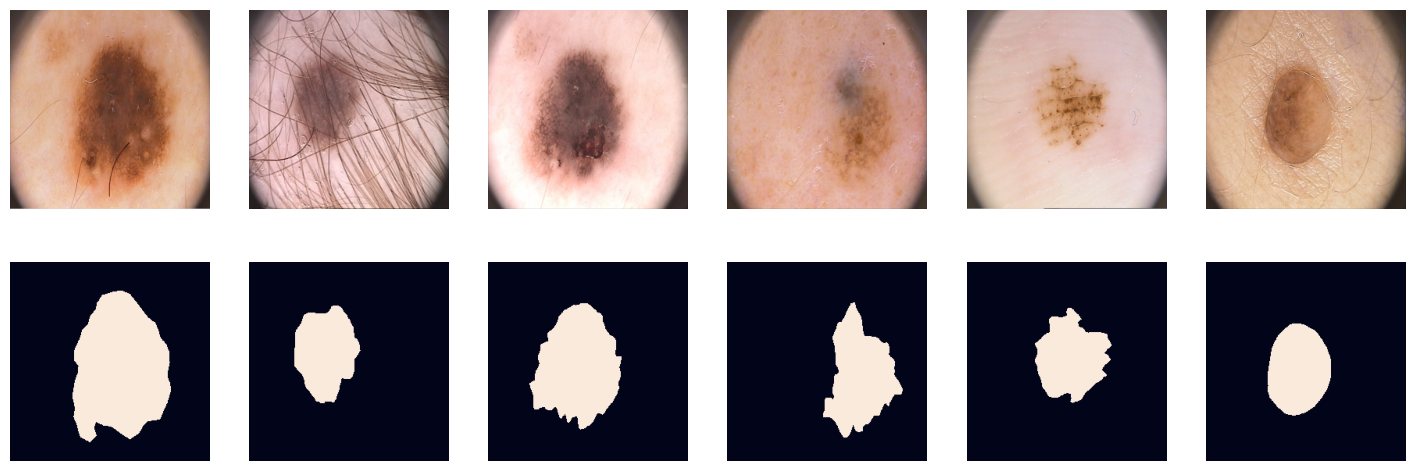

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [9]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [11]:
#!pip install torchmetrics

In [12]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:
$$
\mathcal L_{BCE}(y, \hat y)
= -\sum_i\Bigl[y_i\log\sigma(\hat y_i)+(1-y_i)\log\bigl(1-\sigma(\hat y_i)\bigr)\Bigr],
\tag{1}
$$
где \(\sigma(z)=\frac1{1+e^{-z}}\). G\Положим \(z=\hat y\), \(y=y_i\).

 1. Выражаем логарифмы через \(z\)

$$
\log\sigma(z)
= \log\frac1{1+e^{-z}}
= -\log\bigl(1+e^{-z}\bigr),
$$

$$
\log\bigl(1-\sigma(z)\bigr)
= \log\!\Bigl(\frac{e^{-z}}{1+e^{-z}}\Bigr)
= -z - \log\bigl(1+e^{-z}\bigr).
$$

 2. Подставляем в функцию потерь для одного примера

Обозначим
\(\ell = \mathcal L_{BCE}(y,z)\). Тогда

$$
\begin{aligned}
\ell
&= -\Bigl[y\bigl(-\log(1+e^{-z})\bigr)+(1-y)\bigl(-z-\log(1+e^{-z})\bigr)\Bigr] \\
&= y\log(1+e^{-z}) \;+\;(1-y)\,z \;+\;(1-y)\log(1+e^{-z}).
\end{aligned}
$$

 3. Группируем слагаемые

Заметим, что
$$
y\log(1+e^{-z}) + (1-y)\log(1+e^{-z})
= \bigl[y + (1-y)\bigr]\log(1+e^{-z})
= \log(1+e^{-z}).
$$

Поэтому

$$
\ell
= (1-y)\,z \;+\; \log(1+e^{-z}).
$$

 4. Получаем окончательную формулу

Поскольку \((1-y)z = z - y\,z\), имеем

$$
\ell
= z - y\,z + \log\bigl(1+e^{-z}\bigr),
$$

что и совпадает с
$$
\mathcal L_{BCE}
= \hat y - y\,\hat y + \log\bigl(1+e^{-\hat y}\bigr).
\tag{2}
$$**

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [13]:
import torch.nn.functional as F
import torch.nn as nn

In [14]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [15]:
def bce_loss(y_pred, y_real):
  sig = torch.sigmoid(y_pred)
  return torch.sum(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

def bce_true(y_pred, y_real):
  sig = torch.sigmoid(y_pred)
  return torch.sum(-(y_real*torch.log(sig) + (1-y_real)*torch.log(1-sig)))

Проверим корректность работы на простом примере

In [16]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 3.5899572372436523
BCE loss честно посчитанный = 3.5899572372436523
BCE loss from torch bce_torch = 3.5899572372436523
BCE loss from torch with logits bce_torch = 3.5899572372436523


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [17]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [18]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 19.6356258392334
BCE loss честно посчитанный = 19.6356258392334
BCE loss from torch bce_torch = 19.6356258392334
BCE loss from torch with logits bce_torch = 19.6356258392334


In [19]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [20]:
!pip install gdown

In [21]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt


Retrieving folder contents
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: C:\Users\tsago\PycharmProjects\dls_hw\week_08_semantic_segmentation\Homework\for_asserts\labels.pt

  0%|          | 0.00/1.18k [00:00<?, ?B/s]
100%|##########| 1.18k/1.18k [00:00<00:00, 9.35MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: C:\Users\tsago\PycharmProjects\dls_hw\week_08_semantic_segmentation\Homework\for_asserts\logits.pt

  0%|          | 0.00/1.18k [00:00<?, ?B/s]
100%|##########| 1.18k/1.18k [00:00<00:00, 11.0MB/s]
Download completed


In [22]:
path_to_dummy_samples = 'for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

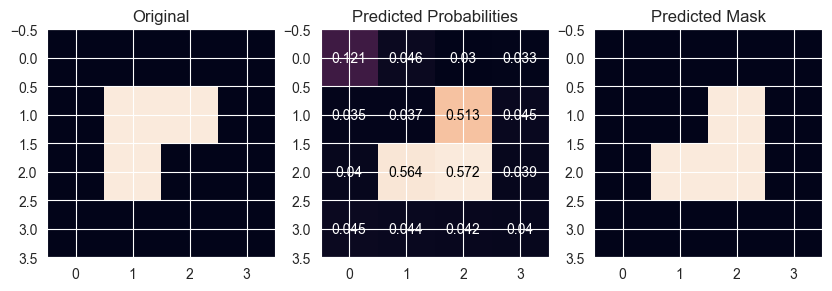

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [24]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

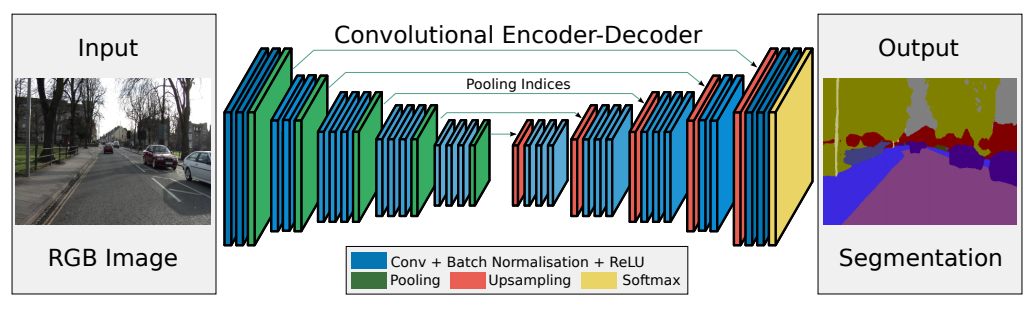

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [26]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # VGG-16 architecture
        # TODO
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)
#----------------2------------------
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)
#----------------3------------------
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, 2)

#----------------4------------------
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool4 = nn.MaxPool2d(2, 2)

#----------------5------------------
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool5 = nn.MaxPool2d(2, 2)

#-------------bottleneck-----------
        # TODO
        self.bottleneck = nn.Conv2d(512, 512, kernel_size=1)
#--------------5------------
        # decoder (upsampling)
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
#--------------4------------
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.conv7 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
#--------------3------------
        self.upsample3 = nn.Upsample(scale_factor=2)
        self.conv8 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
#--------------2------------
        self.upsample4 = nn.Upsample(scale_factor=2)
        self.conv9 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
#--------------1------------
        self.upsample5 = nn.Upsample(scale_factor=2)
        self.conv10 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )

    def forward(self, x):
        # encoder
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.pool4(self.conv4(x))
        x = self.pool5(self.conv5(x))
        # bottleneck
        x = self.bottleneck(self.conv6(x))
        # decoder
        x = self.conv6(self.upsample1(x))
        x = self.conv7(self.upsample2(x))
        x = self.conv8(self.upsample3(x))
        x = self.conv9(self.upsample4(x))
        x = self.conv10(self.upsample5(x))
        output = x
        return output # no activation

In [27]:
segnet_model = SegNet().to(device)

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [28]:
from tqdm.notebook import tqdm

In [29]:
from torchmetrics import JaccardIndex
from IPython.display import clear_output
def train(model, optimizer, criterion, train_loader, valid_loader, epochs, device):
    log_template = (
        "\nEpoch {ep:03d} "
        "train_loss: {t_loss:0.4f} val_loss: {v_loss:0.4f} "
        "train_iou: {t_iou:0.4f} val_iou: {v_iou:0.4f}"
    )

    all_train_loss, all_train_iou, all_val_loss, all_val_iou = [], [], [], []
    best_val_loss = float('inf')

    # берем один батч для визуализации
    vis_batch = next(iter(valid_loader))
    vis_images, vis_masks = vis_batch[0].to(device), vis_batch[1].to(device)

    for epoch in range(1, epochs+1):
        # --- training epoch ---
        model.train()
        total_loss = 0.0
        # инициализируем метрику бинарного IoU
        iou_metric = JaccardIndex(task='binary', threshold=0.5).to(device)

        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            # для BCEWithLogitsLoss таргет float того же shape что logits
            Y_batch = Y_batch.to(device).float()  # [N,1,H,W]

            logits = model(X_batch)                # [N,1,H,W]
            loss   = criterion(logits, Y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # рассчитываем preds и target для IoU
            probs  = torch.sigmoid(logits)             # [N,1,H,W]
            preds  = (probs > 0.5).long().squeeze(1)    # [N,H,W]
            target = Y_batch.long().squeeze(1)          # [N,H,W]
            iou_metric.update(preds, target)

        train_loss = total_loss / len(train_loader)
        train_iou  = iou_metric.compute().item()

        # --- validation epoch ---
        model.eval()
        total_loss = 0.0
        iou_metric = JaccardIndex(task='binary', threshold=0.5).to(device)
        with torch.no_grad():
            for X_batch, Y_batch in valid_loader:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device).float()

                logits = model(X_batch)
                loss   = criterion(logits, Y_batch)

                total_loss += loss.item()

                probs  = torch.sigmoid(logits)
                preds  = (probs > 0.5).long().squeeze(1)
                target = Y_batch.long().squeeze(1)
                iou_metric.update(preds, target)

        val_loss = total_loss / len(valid_loader)
        val_iou  = iou_metric.compute().item()

        all_train_loss.append(train_loss)
        all_train_iou.append(train_iou)
        all_val_loss.append(val_loss)
        all_val_iou.append(val_iou)


        # логируем
        print(log_template.format(
            ep=epoch, t_loss=train_loss, v_loss=val_loss,
            t_iou=train_iou, v_iou=val_iou
        ))

        # визуализация (оставляем ваш код)
        with torch.no_grad():
            vis_logits = model(vis_images)
            vis_preds  = (torch.sigmoid(vis_logits) > 0.5).long().squeeze(1)
        clear_output(wait=True)

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(vis_images[0].cpu().permute(1,2,0).numpy())
        axes[0].set_title('Original'); axes[0].axis('off')
        axes[1].imshow(vis_masks[0].cpu().squeeze(), cmap='gray')
        axes[1].set_title('True Mask'); axes[1].axis('off')
        axes[2].imshow(vis_preds[0].cpu(), cmap='gray')
        axes[2].set_title('Pred Mask'); axes[2].axis('off')
        plt.show()

    return {
        'train_loss': all_train_loss,
        'train_iou':  all_train_iou,
        'val_loss':   all_val_loss,
        'val_iou':    all_val_iou
    }


Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [30]:
ckpt_path = 'for_asserts'
optimizer = optim.Adam(segnet_model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
history = train(model=segnet_model, optimizer=optimizer, criterion=criterion, train_loader=train_dataloader, valid_loader=valid_dataloader, epochs=50, device=device, ckpt_path=ckpt_path)

"\nckpt_path = 'for_asserts'\noptimizer = optim.Adam(segnet_model.parameters(), lr=0.001)\ncriterion = nn.BCEWithLogitsLoss()\nhistory = train(model=segnet_model, optimizer=optimizer, criterion=criterion, train_loader=train_dataloader, valid_loader=valid_dataloader, epochs=50, device=device, ckpt_path=ckpt_path)"

In [31]:
all_train_loss = history['train_loss']
all_train_iou = history['train_iou']
all_val_loss = history['val_loss']
all_val_iou = history['val_iou']
best_val_loss = history['best_val_loss']
num_epochs = len(all_train_loss)
epochs = list(range(1, num_epochs + 1))

NameError: name 'history' is not defined

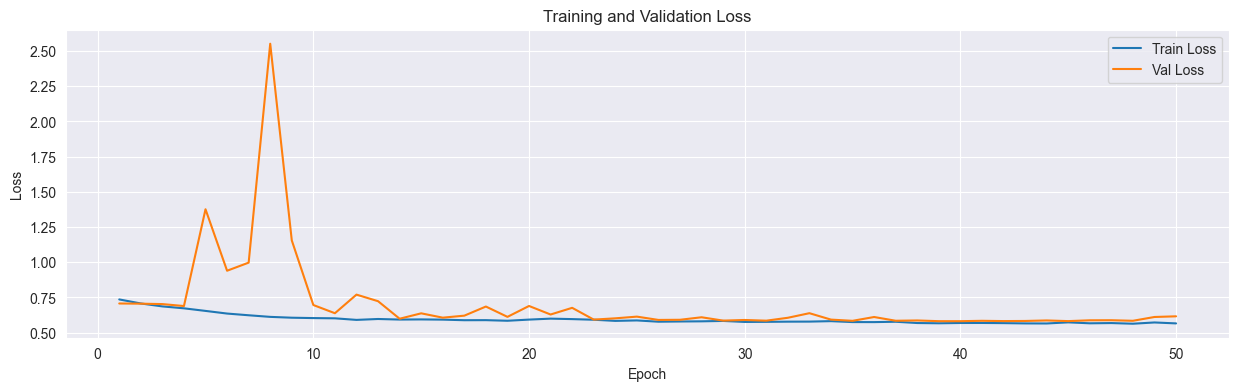

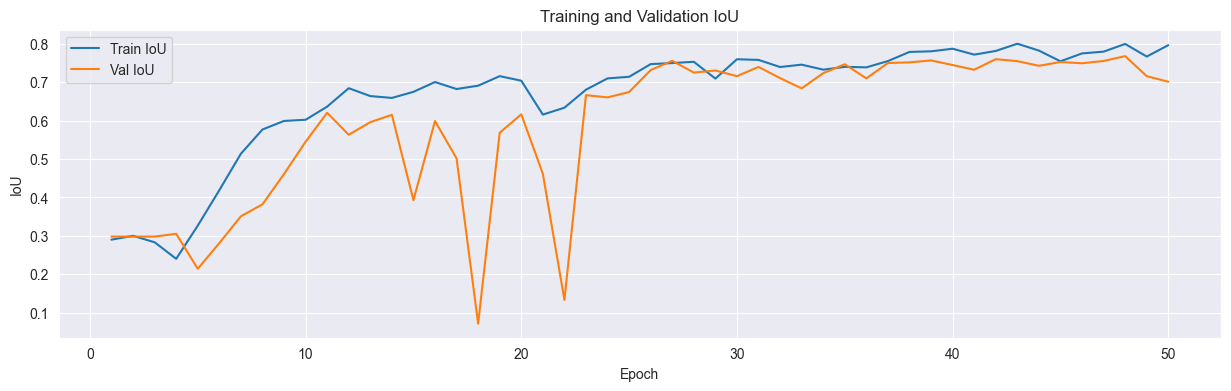

In [47]:
plt.figure()
plt.plot(epochs, all_train_loss, label='Train Loss')
plt.plot(epochs, all_val_loss,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 2) График IoU
plt.figure()
plt.plot(epochs, all_train_iou, label='Train IoU')
plt.plot(epochs, all_val_iou,   label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training and Validation IoU')
plt.legend()
plt.show()

## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [32]:
def test(model, test_loader, device):
    model.eval()
    avg_iou = 0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device).float()
            Y_pred = model(X_batch.to(device))
            avg_iou += iou_score(Y_pred, Y_batch)
        avg_iou /= len(test_loader)
    return avg_iou

In [33]:
#test(segnet_model, test_dataloader, device)

# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [34]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    probs = torch.sigmoid(logits)
    probs = (probs > threshold).float()
    labels = labels.float()

    tp = (probs * labels).sum()
    fp = probs.sum() - tp
    fn = labels.sum() - tp
    eps = 1e-8
    score = (2*tp+eps)/(2*tp+fp+fn+eps)

    return score

Проверим на корректность функцию dice_score:

In [35]:
from torchmetrics.segmentation import DiceScore


dice = DiceScore(average='micro', num_classes=1).to(device)
dice(dummpy_sample['logits'].sigmoid()>0.5, dummpy_sample['labels'].to(int))

tensor(0.6667, device='cuda:0')

In [36]:
assert dice(dummpy_sample['logits'].sigmoid()>0.5, dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [37]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):
    probs = torch.sigmoid(logits)
    labels = labels.float().unsqueeze(1) if labels.ndim == probs.ndim-1 else labels.float()
    dims = (1,2,3)
    intersection = (probs * labels).sum(dim=dims)
    cardinality  = probs.sum(dim=dims) + labels.sum(dim=dims)
    dice_score   = (2*intersection + 1e-8) / (cardinality + 1e-8)
    return (1 - dice_score).mean()

Проверка на корректность:

In [38]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [39]:
print(dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)))
print('\n')
print(dice_loss(dummpy_sample['logits'], dummpy_sample['labels']))
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')


tensor(0.5756, device='cuda:0')


### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [40]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    sig = torch.sigmoid(y_pred)

    return -torch.sum(((1-(sig*y_real + (1-sig)*(1-y_real)))**gamma)*(y_real*torch.log(sig) + (1-y_real)*torch.log(1-sig)) )

Проверка корректности функции:

In [41]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [42]:
assert torch.isclose(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') , focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0))

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

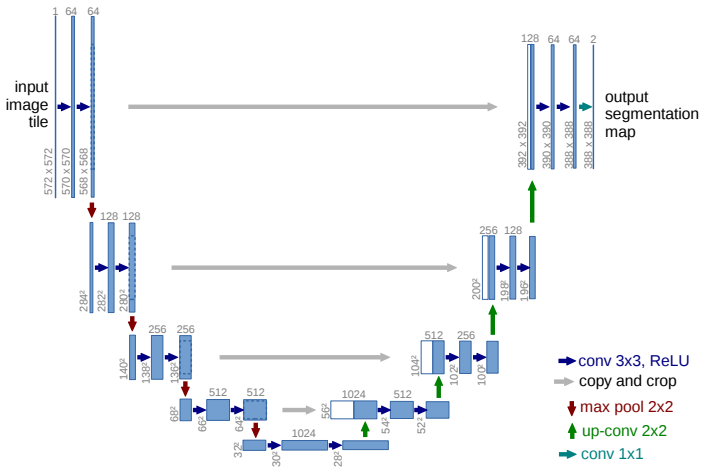

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [43]:
import torch
#torch.cuda.empty_cache()

In [44]:
import torch.nn.functional as F
import torch.nn as nn

In [45]:
class decoder(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        self.conv1 = nn.Conv2d(inp, out, 3, padding=1)
        self.conv2 = nn.Conv2d(out, out, 3, padding=1)
        self.fa = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.fa(x)
        x = self.conv2(x)
        x = self.fa(x)
        return x

class downsampler(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        self.conv1 = decoder(inp, out)
        self.pool = nn.MaxPool2d(2, 2)
    def forward(self, x):
        x = self.conv1(x)
        p = self.pool(x)
        return x, p

class upsampler(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        self.trans1 = nn.ConvTranspose2d(inp, out, kernel_size=2, stride=2)
        self.conv1 = decoder(out+out, out)
    def forward(self, x, skips):
        x = self.trans1(x)
        x = self.conv1(torch.cat([x, skips], 1))
        return x


class UNet(nn.Module):

    def __init__(self, n_class=1):
        super().__init__()
        #decoder
        self.dec1 = downsampler(3, 64)
        self.dec2 = downsampler(64, 128)
        self.dec3 = downsampler(128, 256)
        self.dec4 = downsampler(256, 512)
        #bottleneck
        self.bottleneck = decoder(512, 1024)
        #encoder
        self.enc1 = upsampler(1024, 512)
        self.enc2 = upsampler(512, 256)
        self.enc3 = upsampler(256, 128)
        self.enc4 = upsampler(128, 64)
        #out
        self.out = nn.Conv2d(64, n_class, 1)



    def forward(self, x):
        b1, a1 = self.dec1(x)
        b2, a2 = self.dec2(a1)
        b3, a3 = self.dec3(a2)
        b4, a4 = self.dec4(a3)

        a5 = self.bottleneck(a4)

        x = self.enc1(a5, b4)
        x = self.enc2(x, b3)
        x = self.enc3(x, b2)
        x = self.enc4(x, b1)

        output = self.out(x)


        return output

In [46]:
#unet_model = UNet().to(device)

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



In [47]:

import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchmetrics import JaccardIndex

def train(model, criterion, train_loader, val_loader, epochs, device):
    # захватим одну пару для визуализации
    vis_X, vis_Y = next(iter(val_loader))
    vis_X, vis_Y = vis_X.to(device), vis_Y.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_iou_metric = JaccardIndex(task='binary', threshold=0.5).to(device)
    val_iou_metric   = JaccardIndex(task='binary', threshold=0.5).to(device)

    all_train_loss, all_train_iou = [], []
    all_val_loss,   all_val_iou   = [], []

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        train_iou_metric.reset()
        for X, Y in train_loader:
            X, Y = X.to(device), Y.to(device)
            logits = model(X)
            loss   = criterion(logits, Y)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long().squeeze(1)  # [N,H,W]
            target= Y.long().squeeze(1)              # [N,H,W]
            train_iou_metric.update(preds, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        train_iou  = train_iou_metric.compute().item()
        all_train_loss.append(train_loss)
        all_train_iou.append(train_iou)

        # ---- VALID ----
        model.eval()
        total_loss = 0.0
        val_iou_metric.reset()
        with torch.no_grad():
            for X, Y in val_loader:
                X, Y = X.to(device), Y.to(device)
                logits = model(X)
                loss   = criterion(logits, Y)

                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).long().squeeze(1)
                target= Y.long().squeeze(1)
                val_iou_metric.update(preds, target)

                total_loss += loss.item()

        val_loss = total_loss / len(val_loader)
        val_iou  = val_iou_metric.compute().item()
        all_val_loss.append(val_loss)
        all_val_iou.append(val_iou)

        clear_output(wait=True)

        epochs_range = list(range(1, epoch+1))
        plt.figure(figsize=(10,4))
        plt.plot(epochs_range, all_train_loss, label='Train Loss')
        plt.plot(epochs_range, all_val_loss,   label='Val Loss')
        plt.plot(epochs_range, all_train_iou,  label='Train IoU')
        plt.plot(epochs_range, all_val_iou,    label='Val IoU')
        plt.xlabel('Epoch')
        plt.legend()
        plt.title(f'Epoch {epoch}')
        plt.grid(True)
        plt.show()

        with torch.no_grad():
            vis_logits = model(vis_X)
            vis_pred   = (torch.sigmoid(vis_logits) > 0.5).float()

        plt.figure(figsize=(12,4))
        # оригинал
        plt.subplot(1,3,1)
        plt.imshow(vis_X[0].cpu().permute(1,2,0).numpy())
        plt.title('Original'); plt.axis('off')
        # ground-truth
        plt.subplot(1,3,2)
        plt.imshow(vis_Y[0].cpu().squeeze(), cmap='gray')
        plt.title('True Mask'); plt.axis('off')
        # предсказание
        plt.subplot(1,3,3)
        plt.imshow(vis_pred[0].cpu().squeeze(), cmap='gray')
        plt.title('Predicted Mask'); plt.axis('off')
        plt.show()

    return {
        'train_loss': all_train_loss,
        'train_iou' : all_train_iou,
        'val_loss'  : all_val_loss,
        'val_iou'   : all_val_iou
    }



"\nimport matplotlib.pyplot as plt\nfrom IPython.display import clear_output\nfrom torchmetrics import JaccardIndex\n\ndef train(model, criterion, train_loader, val_loader, epochs, device):\n    # захватим одну пару для визуализации\n    vis_X, vis_Y = next(iter(val_loader))\n    vis_X, vis_Y = vis_X.to(device), vis_Y.to(device)\n\n    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)\n\n    # создаём метрики один раз и сразу отправляем на device\n    train_iou_metric = JaccardIndex(task='binary', threshold=0.5).to(device)\n    val_iou_metric   = JaccardIndex(task='binary', threshold=0.5).to(device)\n\n    all_train_loss, all_train_iou = [], []\n    all_val_loss,   all_val_iou   = [], []\n\n    for epoch in range(1, epochs+1):\n        # ---- TRAIN ----\n        model.train()\n        total_loss = 0.0\n        train_iou_metric.reset()\n        for X, Y in train_loader:\n            X, Y = X.to(device), Y.to(device)\n            logits = model(X)                 # [N,1,H,W]\n   

In [48]:
from segmentation_models_pytorch.losses import FocalLoss, DiceLoss
from torch import optim

bce_loss = nn.BCELoss(reduction='sum')
dice_loss = DiceLoss(mode='binary')
focal_loss = FocalLoss(mode='binary')

In [49]:
unet_model_bce = UNet().to(device)
unet_model_dice = UNet().to(device)
unet_model_focal = UNet().to(device)

In [50]:
optimizer=optim.Adam(unet_model_bce.parameters(), lr=0.001)
history_bce = train(model = unet_model_bce, criterion= bce_loss, train_loader= train_dataloader, valid_loader= valid_dataloader, epochs=40, device= device, optimizer=optimizer)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
history_dice = train(unet_model_dice, dice_loss, train_dataloader, valid_dataloader, epochs=40)

In [ ]:
history_focal = train(unet_model_focal, focal_loss, train_dataloader, valid_dataloader, epochs=40)